## 2: Scalecast LSTM Model

Lucy Herr
<br>  3/1/24
<br>  UCB MIDS Capstone Spring 2024

scalecast lstm sources: 
- https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#lstm
- https://scalecast-examples.readthedocs.io/en/latest/lstm/lstm_latest.html
- https://towardsdatascience.com/five-practical-applications-of-the-lstm-model-for-time-series-with-code-a7aac0aa85c0
- https://mikekeith52.medium.com/stacking-time-series-models-to-improve-accuracy-7977c6667d29
- https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf

Tensorflow LSTM sources:
- best/most comprehensive documentation: https://www.tensorflow.org/tutorials/structured_data/time_series
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
- https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce
- https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html

general lstm:
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/ 

In [ ]:
import pandas as pd
import numpy as np 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# LSTM forecasting
from scalecast.Forecaster import Forecaster
# grid search
from scalecast import GridGenerator

# pipeline
from scalecast.Pipeline import Transformer, Reverter, Pipeline
from scalecast.util import (
    find_optimal_transformation,
    gen_rnn_grid,
    backtest_for_resid_matrix,
    get_backtest_resid_matrix,
    overwrite_forecast_intervals,
    infer_apply_Xvar_selection,
)
from tensorflow.keras.callbacks import EarlyStopping
from scalecast.MVForecaster import MVForecaster
from scalecast.Pipeline import MVPipeline
from scalecast.util import find_optimal_transformation, backtest_metrics

In [139]:
# lstm_train = pd.read_csv("split_data/lstm_train.csv")
# lstm_val = pd.read_csv("split_data/lstm_val.csv")
lstm_trainval = pd.read_csv("split_data/lstm_trainval.csv")

### Initialize Forecaster object for modeling

In [27]:
# initialize forecaster model
f0 = Forecaster(
    y=y_train.county_all_drugs_monthly_rate, # array of all observed y-vals
    current_dates=lstm_train.period, # array of all observed dates
    require_future_dates=True, # default
    future_dates=6, # default
    test_length=0, # validation set to consist of 20% of train observations
    cis=False, # evaluate naive conformal CIs for each model, default=False
    metrics = ['rmse'] # default metrics for validation
)
# display object attributes
f0

Forecaster(
    DateStartActuals=2016-02-01T00:00:00.000000000
    DateEndActuals=2021-08-01T00:00:00.000000000
    Freq=None
    N_actuals=3856
    ForecastLength=6
    Xvars=[]
    TestLength=771
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [82]:
# initialize forecaster model
f1 = Forecaster(
    y=lstm_trainval.county_all_drugs_monthly_rate, # array of all observed y-vals
    current_dates=lstm_trainval.period, # array of all observed dates
    require_future_dates=True, # default
    future_dates=50, # default
    test_length=.5, # validation set to consist of 20% of train observations
    cis=False, # evaluate naive conformal CIs for each model, default=False
    metrics = ['rmse'] # default metrics for validation
)
# display object attributes
f1

Forecaster(
    DateStartActuals=2016-02-01T00:00:00.000000000
    DateEndActuals=2022-05-01T00:00:00.000000000
    Freq=None
    N_actuals=4408
    ForecastLength=50
    Xvars=[]
    TestLength=2204
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Test series' stationarity 

In [62]:
# Test for stationarity in series: Augmented Dickey-Fuller test
stat, pval, used_lag_int, n_obs, crit_vals_dict, res_class = f0.adf_test(critical_pval=0.05, full_res=True, train_only=True, diffy=False)
print(f"The ADF test of the training data's stationarity was significant (p={pval}).")

The ADF test of the training data's stationarity was significant (p=1.8921549612503203e-07).


In [43]:
# descriptive plot of observed values --> refine this with finalized data to make more 
# f.plot()
# plt.show()

### Inspect Autocorrelation: ACF Plot
- caveat: not suitable for non-stationary time series

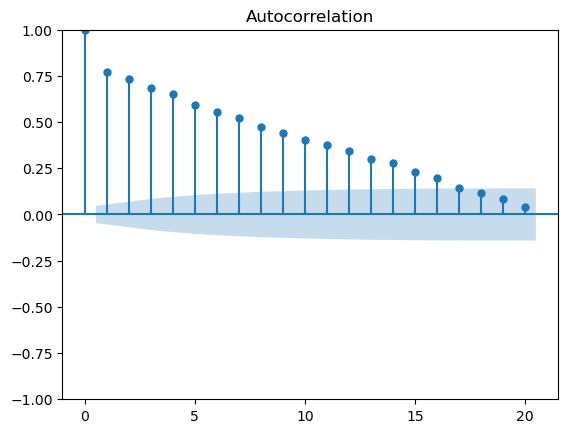

In [51]:
f0.plot_acf(lags=20)
plt.show()

Observations based on ACF plot: 
- Only sharp cutoff occurs between lag 0 and lag 1.
- Statistically non-0 ACF values through lag1-16 
- Gradual, visually linear decay from lag 1 onwards 

### Inspect Partial Autocorrelation: PACF Plot
- caveat: not suitable for non-stationary time series

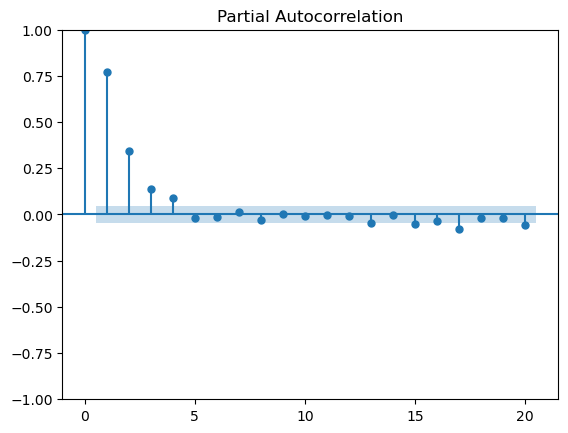

In [52]:
# # partial correlation of stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. 
f0.plot_pacf(lags=20)
plt.show()

Observations based on PACF plot: 
- Sharp decreases in PACF values following lag=1 and lag=2 (and, to a lesser extent, lag=3) may suggest seasonal patterns relevant for modeling. 
- This plot does not show gradual decay indicative of seasonality.
- Most values from lag 5 upwards fall within 95% CI (not statistically non-zero), with the exception of 13,15,17,20 (all slightly negative)

In [67]:
# decompose series into trend, seasonal, and residual components
# #ERROR: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

# f0.seasonal_decompose().plot()
# plt.show()

### Build and Train Initial LSTM Model

In [162]:
f3 = Forecaster(
    y=lstm_trainval.county_all_drugs_monthly_rate, # array of all observed y-vals
    current_dates=lstm_trainval.period, # array of all observed dates
    require_future_dates=True, # default
    future_dates=10, # default
    test_length=12, # validation set to consist of 20% of train observations
    cis=False, # evaluate naive conformal CIs for each model, default=False
    metrics = ['rmse'] # default metrics for validation
)

#f3.set_test_length(20)       # 1. 12 observations to test the results

f3.set_estimator('lstm') # LSTM neural network
f3.manual_forecast(
    lags=1, # adjust - likely too large 
    batch_size=15, # likely too large 
    epochs=5, # likely more than we need 
    call_me='lstm3',
    validation_split=.2,
    activation='tanh', # experiment with activation 
    optimizer='Adam', # experiment with optimization
    learning_rate=0.001, # ""
    lstm_layer_sizes=(4,)*3, # likely MUCH too large --> conducive to overfit 
    dropout=(0,)*3, # probably excessive
    loss='MeanSquaredError'
)

Epoch 1/5
234/234 [==============================] - 4s 5ms/step - loss: 6.0736e-04 - val_loss: 3.1155e-04
Epoch 2/5
234/234 [==============================] - 0s 2ms/step - loss: 6.0764e-04 - val_loss: 3.1228e-04
Epoch 3/5
234/234 [==============================] - 0s 2ms/step - loss: 6.0721e-04 - val_loss: 3.1279e-04
Epoch 4/5
234/234 [==============================] - 0s 2ms/step - loss: 6.0701e-04 - val_loss: 3.1275e-04
Epoch 5/5
1/1 [==============================] - 1s 589ms/step
Epoch 1/5
235/235 [==============================] - 4s 5ms/step - loss: 6.0775e-04 - val_loss: 3.0570e-04
Epoch 2/5
235/235 [==============================] - 0s 2ms/step - loss: 6.0706e-04 - val_loss: 3.0419e-04
Epoch 3/5
235/235 [==============================] - 0s 2ms/step - loss: 6.0664e-04 - val_loss: 3.0183e-04
Epoch 4/5
235/235 [==============================] - 0s 2ms/step - loss: 6.0722e-04 - val_loss: 3.0604e-04
Epoch 5/5
138/138 [==============================] - 0s 796us/step


In [ ]:
# get predictions - not working yet 
# preds = f3.predict(
#     transfer_from = f,
#     model = 'lstm',
#     dates = pd.date_range(start='2021-01-01',end='2023-12-31',freq='MS'),
#     save_to_history=False,
#     return_series=True,
# )
# preds

In [30]:
# calc rmse from val loss? 
np.sqrt(3.7697e-04)

0.019415715284274233

## TO DO: Grid search 

In [ ]:
# rnn_grid = gen_rnn_grid(
#     layer_tries = 10,
#     min_layer_size = 3,
#     max_layer_size = 5,
#     units_pool = [100],
#     epochs = [100],
#     dropout_pool = [0,0.05],
#     validation_split=.2,
#     callbacks=EarlyStopping(
#       monitor='val_loss',
#       patience=3,
#     ),
#     random_seed = 20,
) # creates a grid of hyperparameter values to tune the LSTM model

In [159]:
# alternative manual_forecast syntax to build function? 

# def forecaster(f):
#     f.set_estimator('rnn')
#     f.manual_forecast(
#         lags = 2,
#         layers_struct = [
#             ('LSTM',{'units':36,'activation':'tanh'}),
#         ],
#         epochs=5,
#         call_me = 'lstm',
#     )

121/121 [==============================] - 0s 555us/step


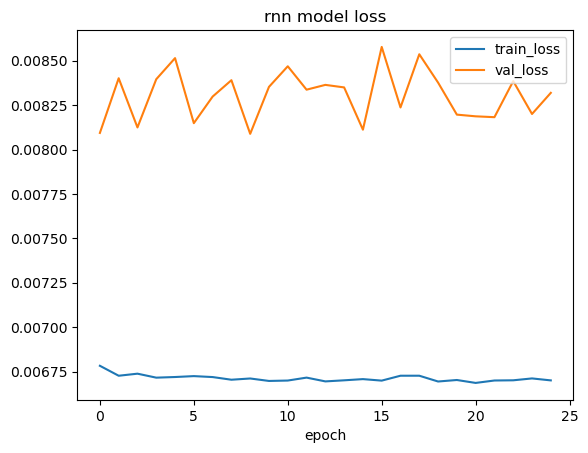

In [59]:
f0.manual_forecast(
    layers_struct=[('LSTM',{'units':36,'activation':'tanh'}))],
    epochs=25,
    validation_split=0.2,
    plot_loss=True,
    call_me="lstm2",
    verbose=0, # so it doesn't print each epoch and saves space in the notebook
)

### 'lstm_simple' (default LSTM settings)

#### scalecast LSTM defaults (from documentation): 
- single input layer of size 8, Adam optimizer, tanh activation, a single lagged dependent-variable value to train with, 
- a learning rate of 0.001, and no dropout.
- All data is scaled going into the model with a min-max scaler and un-scaled coming out.
- Anything you can pass to the fit() method in TensorFlow, you can also pass to the scalecast manual_forecast() method.
- f.manual_forecast(call_me='lstm_default')
- f.plot_test_set(ci=True)

138/138 [==============================] - 0s 499us/step


<Axes: xlabel='Date', ylabel='Values'>

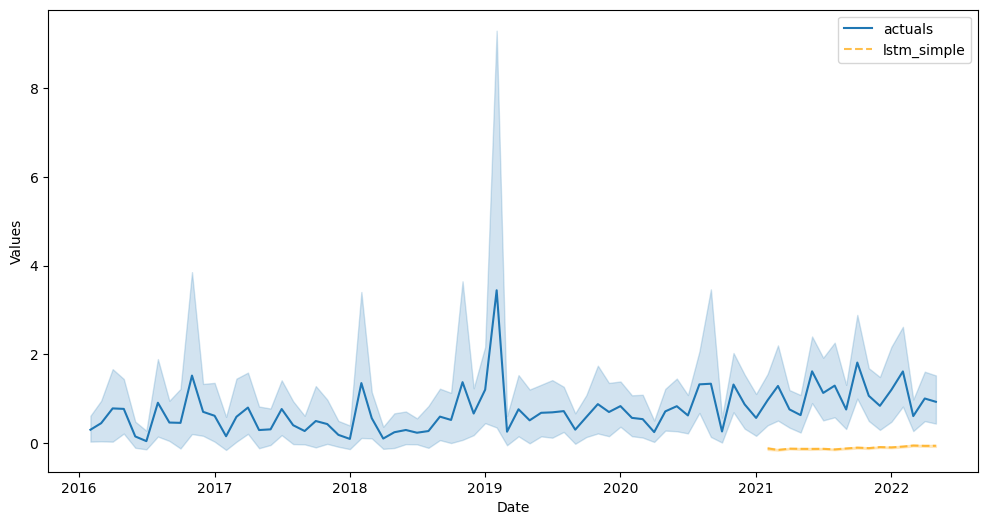

In [153]:





f3.set_estimator('lstm')
f3.manual_forecast(call_me='lstm_simple',lags=1)
f3.plot_test_set(ci=False,models=['lstm_simple'],order_by='TestSetRMSE')

### 'lstm_4layer'

<Axes: xlabel='Date', ylabel='Values'>

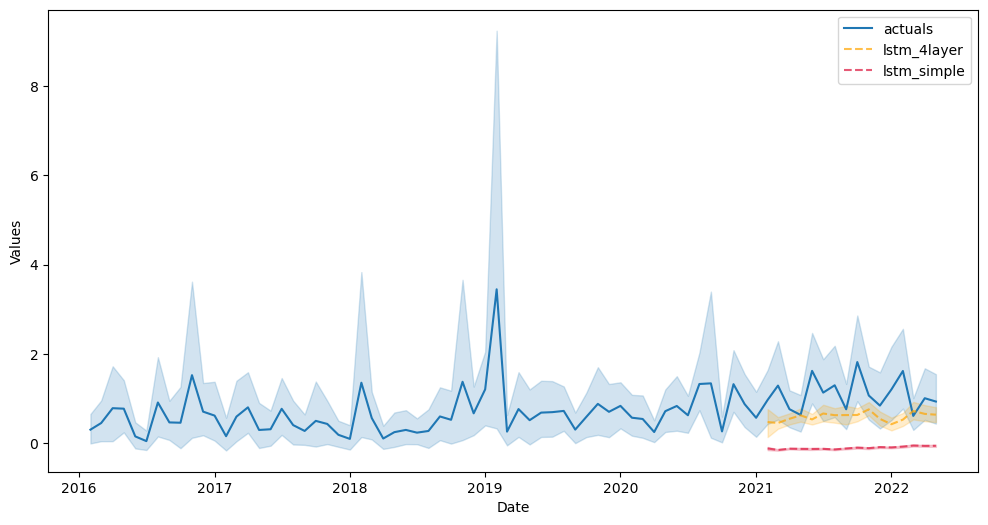

In [154]:
f3.manual_forecast(
    #lags=1, # adjust - likely too large 
    batch_size=15, # likely too large 
    epochs=5, # likely more than we need 
    call_me='lstm_4layer',
    validation_split=.3,
    activation='tanh', # experiment with activation 
    optimizer='Adam', # experiment with optimization
    learning_rate=0.005, # ""
    lstm_layer_sizes=(16,)*3, # likely MUCH too large --> conducive to overfit 
    dropout=(0,)*3, # probably excessive
    loss='MeanSquaredError'
)

f3.plot_test_set(ci=False,models=['lstm_simple','lstm_4layer'],order_by='TestSetRMSE')

### 'lstm_4layer_1lag'

Epoch 1/5
124/124 [==============================] - 4s 8ms/step - loss: 7.1955e-04 - val_loss: 6.3828e-04
Epoch 2/5
124/124 [==============================] - 0s 2ms/step - loss: 7.1825e-04 - val_loss: 6.3832e-04
Epoch 3/5
124/124 [==============================] - 0s 2ms/step - loss: 7.1829e-04 - val_loss: 6.3858e-04
Epoch 4/5
124/124 [==============================] - 0s 2ms/step - loss: 7.1841e-04 - val_loss: 6.3834e-04
Epoch 5/5
1/1 [==============================] - 1s 784ms/step
Epoch 1/5
206/206 [==============================] - 4s 5ms/step - loss: 6.2725e-04 - val_loss: 3.5790e-04
Epoch 2/5
206/206 [==============================] - 0s 2ms/step - loss: 6.2670e-04 - val_loss: 3.5864e-04
Epoch 3/5
206/206 [==============================] - 0s 2ms/step - loss: 6.2687e-04 - val_loss: 3.5667e-04
Epoch 4/5
206/206 [==============================] - 0s 2ms/step - loss: 6.2735e-04 - val_loss: 3.5854e-04
Epoch 5/5
138/138 [==============================] - 0s 690us/step


<Axes: xlabel='Date', ylabel='Values'>

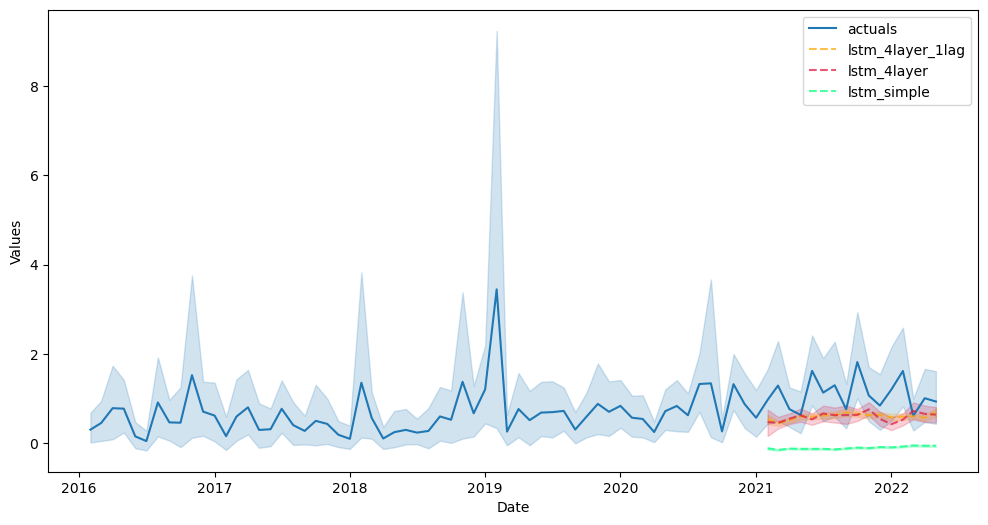

In [155]:
f3.manual_forecast(
    lags=1, # adjust - likely too large 
    batch_size=15, # likely too large 
    epochs=5, # likely more than we need 
    call_me='lstm_4layer_1lag',
    validation_split=.3,
    activation='tanh', # experiment with activation 
    optimizer='Adam', # experiment with optimization
    learning_rate=0.001, # ""
    lstm_layer_sizes=(4,)*3, # likely MUCH too large --> conducive to overfit 
    dropout=(0,)*3, # probably excessive
    loss='MeanSquaredError'
)

f3.plot_test_set(ci=False,models=['lstm_simple','lstm_4layer','lstm_4layer_1lag'],order_by='TestSetRMSE')

### 'lstm_8layer_2lag'

Epoch 1/5
124/124 [==============================] - 4s 9ms/step - loss: 7.4238e-04 - val_loss: 6.6611e-04
Epoch 2/5
124/124 [==============================] - 0s 2ms/step - loss: 7.4222e-04 - val_loss: 6.6527e-04
Epoch 3/5
124/124 [==============================] - 0s 2ms/step - loss: 7.4296e-04 - val_loss: 6.6326e-04
Epoch 4/5
124/124 [==============================] - 0s 2ms/step - loss: 7.4229e-04 - val_loss: 6.6483e-04
Epoch 5/5
1/1 [==============================] - 0s 493ms/step
Epoch 1/5
206/206 [==============================] - 3s 6ms/step - loss: 6.5525e-04 - val_loss: 3.9353e-04
Epoch 2/5
206/206 [==============================] - 0s 2ms/step - loss: 6.4972e-04 - val_loss: 3.7342e-04
Epoch 3/5
206/206 [==============================] - 0s 2ms/step - loss: 6.4943e-04 - val_loss: 4.0195e-04
Epoch 4/5
206/206 [==============================] - 0s 2ms/step - loss: 6.5072e-04 - val_loss: 3.6833e-04
Epoch 5/5
138/138 [==============================] - 0s 769us/step


<Axes: xlabel='Date', ylabel='Values'>

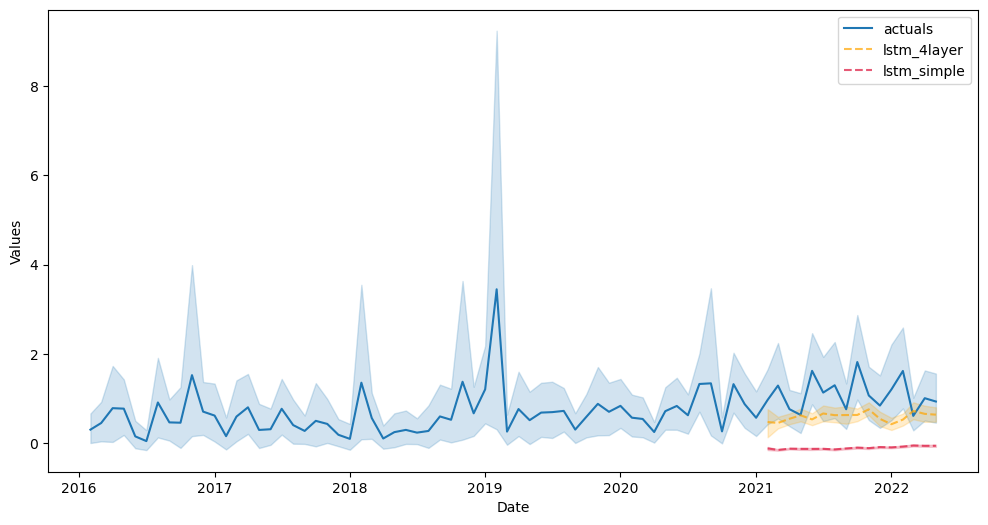

In [156]:
f3.manual_forecast(
    lags=2, # adjust - likely too large 
    batch_size=15, # likely too large 
    epochs=5, # likely more than we need 
    call_me='lstm_8layer_2lag',
    validation_split=.3,
    activation='tanh', # experiment with activation 
    optimizer='Adam', # experiment with optimization
    learning_rate=0.01, # ""
    lstm_layer_sizes=(8,)*3, # likely MUCH too large --> conducive to overfit 
    dropout=(0,)*3, # probably excessive
    loss='MeanSquaredError'
)

# f3.plot_test_set(ci=False,models=['lstm_simple','lstm_4layer','lstm_4layer_2lag'],order_by='TestSetRMSE')

Epoch 1/25
185/185 [==============================] - 7s 15ms/step - loss: 7.4971e-04 - val_loss: 6.6640e-04
Epoch 2/25
185/185 [==============================] - 2s 8ms/step - loss: 7.5022e-04 - val_loss: 6.6930e-04
Epoch 3/25
185/185 [==============================] - 2s 9ms/step - loss: 7.5306e-04 - val_loss: 6.6524e-04
Epoch 4/25
185/185 [==============================] - 2s 8ms/step - loss: 7.5273e-04 - val_loss: 6.6732e-04
Epoch 5/25
185/185 [==============================] - 2s 9ms/step - loss: 7.5351e-04 - val_loss: 6.7071e-04
Epoch 6/25
185/185 [==============================] - 2s 9ms/step - loss: 7.5258e-04 - val_loss: 6.6505e-04
Epoch 7/25
185/185 [==============================] - 1s 8ms/step - loss: 7.5282e-04 - val_loss: 6.6695e-04
Epoch 8/25
185/185 [==============================] - 1s 8ms/step - loss: 7.5266e-04 - val_loss: 6.6646e-04
Epoch 9/25
185/185 [==============================] - 1s 8ms/step - loss: 7.5344e-04 - val_loss: 6.6397e-04
Epoch 10/25
185/185 [======

<Axes: xlabel='Date', ylabel='Values'>

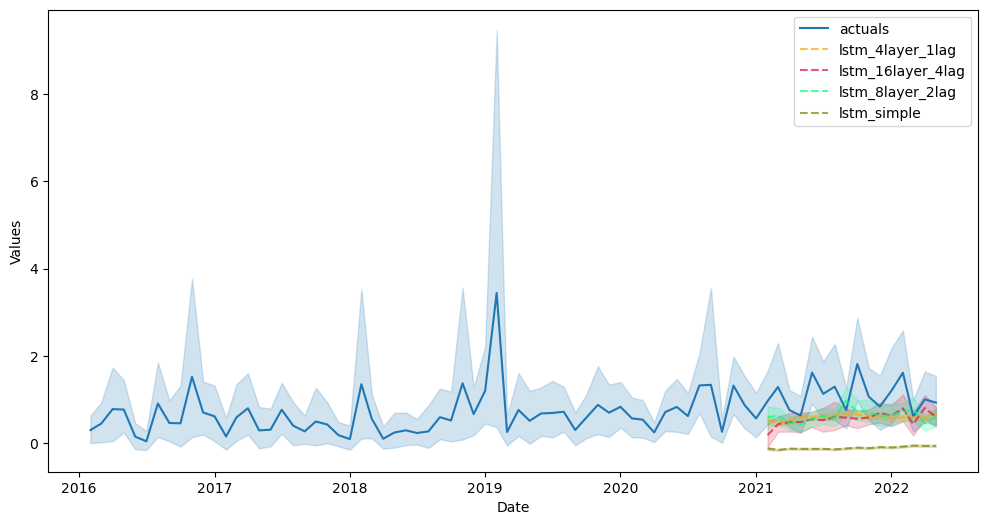

In [157]:
f3.manual_forecast(
    lags=10, # adjust - likely too large 
    batch_size=10, # likely too large 
    epochs=25, # likely more than we need 
    call_me='lstm_16layer_4lag',
    validation_split=.3,
    activation='tanh', # experiment with activation 
    optimizer='Adam', # experiment with optimization
    learning_rate=0.01, # ""
    lstm_layer_sizes=(32,)*5, # likely MUCH too large --> conducive to overfit 
    dropout=(0,)*5, # probably excessive
    loss='MeanSquaredError'
)

f3.plot_test_set(ci=False,models=['lstm_simple','lstm_4layer_1lag','lstm_8layer_2lag','lstm_16layer_4lag'],order_by='TestSetRMSE')

In [ ]:


# try pipeline - not working 

# # pipeline = Pipeline(
# #     steps = [('Forecast',forecaster))
# pipeline = Pipeline(steps = ('Forecast',forecaster))
# f = pipeline.fit_predict(f0)
# f
# from scalecast import GridGenerator

# GridGenerator.get_example_grids()
# models = ['ridge','lasso','xgboost','lightgbm','knn']
# f0.tune_test_forecast(
#     models,
#     limit_grid_size = .2,
#     feature_importance = True, # save pfi feature importance for each model?
#     cross_validate = True, # cross validate? if False, using a seperate validation set that the user can specify
#     rolling = True, # rolling time series cross validation?
#     k = 3, # how many folds?
# )b
# try pipeline - not working yet

# # pipeline = Pipeline(
# #     steps = [('Forecast',forecaster))
# pipeline = Pipeline(steps = ('Forecast',forecaster))
# f = pipeline.fit_predict(f0)
# f

In [158]:
# calc rsme from val loss
np.sqrt(3.6576e-04)

0.019124852940611073

# Tensorflow models

One key to successfully using deep learning with time series data is to split the date into multiple categorical variables 
(year, month, week, day of week, day of month, and Booleans for whether it’s the start/end of a month/quarter/year). 
The fastai library has implemented a method to handle this for you, as described below. -->

### embeddings for categorical vars
The fastai library contains an implementation for categorical variables, which work with Pytorch’s nn.Embedding module, so this is not something you need to code from hand each time you want to use it.

## preprocessing

In [109]:
# split train and validation sets 
df = df_train_temp
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):]

num_features = df.shape[1]

,county_name,PERIOD,BP_Count,BP_Weight,male_pct,ages25_64_pct,Overdose_Rate_X100K
0,ADAMS,2021-02-01,118,796.762695,0.509300,0.543396,3.723128
1,ADAMS,2021-03-01,145,651.891995,0.509300,0.543396,6.701631
2,ADAMS,2021-04-01,140,886.411292,0.509300,0.543396,5.212380
3,ADAMS,2021-05-01,135,949.615541,0.509300,0.543396,6.949840
4,ADAMS,2021-06-01,110,1056.409906,0.509300,0.543396,5.460588
...,...,...,...,...,...,...,...
1756,WORCESTER,2022-08-01,140,2301.461531,0.497093,0.532732,4.522936
1757,WORCESTER,2022-09-01,126,1855.836049,0.497093,0.532732,3.392202
1758,WORCESTER,2022-10-01,119,1050.510483,0.497093,0.532732,5.370987
1759,WORCESTER,2022-11-01,106,1116.009141,0.497093,0.532732,2.968177


In [111]:
# scaling: need to adjust for data leakage 
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


## Tensorflow CNN

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


# Tensorflow RNN 

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)
